In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt

sys.path.append("..")
from src.model.model import HyMMSBM
from src.data.data_io import load_data

# Sampling from the *Hy-MMSBM* generative model

In this notebook we show how to sample synthetic data from *Hy-MMSBM* generative model.

While here we show the inner workings of our implementation, a direct command line interface for training the 
model is available through `main_sampling.py`, which allows to abstract from the underlying Python code. 

To run such code directly, we refer to the explanations in `README.md`.

## Vanilla sampling from the generative model

The most vanilla type of sampling can be performed by only providing the affinity matrix $w$ and community assignments $u$, and sampling from the distribution $p(A; w, u)$.

For example, assume we want to sample a hypergraph with $N=60$ nodes and $K=3$ equally-sized assortative communities. In addition, we need to decide the maximum size of the hyperedges that we want to generate. Then, we can obtain a synthetic hypegraph as following.

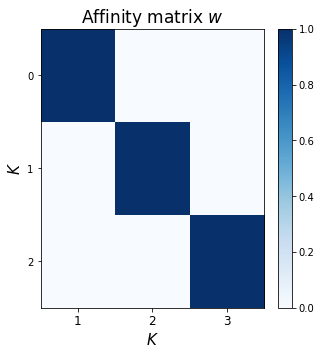

In [2]:
# Diagonal affinity matrix, which results in an assortative structure
w = np.eye(3)

plt.matshow(w, aspect='auto', cmap='Blues')
plt.gcf().set_size_inches(5, 5)
plt.title(r'Affinity matrix $w$', fontsize=17)
plt.xlabel(r'$K$', fontsize=15)
plt.ylabel(r'$K$', fontsize=15)
plt.xticks(ticks=[0,1,2], labels=[1,2,3], size=12)
plt.tick_params(axis='x', bottom=True, top=False, labelbottom=True, labeltop=False)
plt.colorbar()
plt.show()

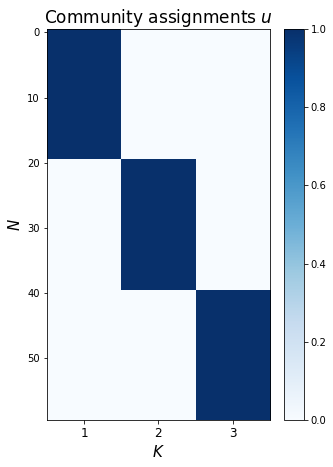

In [3]:
# Community assignments
u = np.zeros((60, 3))
u[:20, 0] = 1
u[20:40, 1] = 1
u[40:, 2] = 1

plt.matshow(u, aspect='auto', cmap='Blues')
plt.gcf().set_size_inches(5, 7)
plt.title(r'Community assignments $u$', fontsize=17)
plt.xlabel(r'$K$', fontsize=15)
plt.ylabel(r'$N$', fontsize=15)
plt.xticks(ticks=[0,1,2], labels=[1,2,3], size=12)
plt.tick_params(axis='x', bottom=True, top=False, labelbottom=True, labeltop=False)
plt.colorbar()
plt.show()

Notice that the generative parameters are very general: 
- the affinity $w$ can be any symmetric $K \times K$ non-nagative matrix 
- the assignments $u$ can be any $N \times K$ non-negative matrix, allowing for mixed-membership as well

Now initialize the model.

In [4]:
model = HyMMSBM(
    u=u, 
    w=w,
    max_hye_size=10
)
sample_generator = model.sample()

Now start the sampling. Recall that the most general form of sampling work as following:
- sample the degree and dimension sequences 
- arrange them in a first hypergraph proposal
- mix the hyperedges of the initial proposal via a Markov Chain, and continuously return the results at different steps of the chain

Since the Markov Chain can be continuously mixed, the number of samples is unlimited and is represented by a generator, as opposed to a finite-length list. 

In [5]:
%%time

for i in range(10):
    print("Getting sample number:", i)
    new_sample, _ = next(sample_generator)

# Get some more samples later in the code
print("Getting another couple of samples...")
_ = next(sample_generator)
_ = next(sample_generator)

Getting sample number: 0


../src/model/model.py:280: RuntimeWarning: divide by zero encountered in log
  log_poisson = np.log(


Getting sample number: 1
Getting sample number: 2
Getting sample number: 3
Getting sample number: 4
Getting sample number: 5
Getting sample number: 6
Getting sample number: 7
Getting sample number: 8
Getting sample number: 9
Getting another couple of samples...
CPU times: user 5.38 s, sys: 113 ms, total: 5.49 s
Wall time: 5.41 s


Notice, however, that all the samples generated from the same call of `HyMMSBM.sample` will have the same degree and size sequence. To have a completely new sample, a new call to the method is needed.

The obtained samples are a `Hypergraph` instance, with various attributes, e.g.

In [6]:
sample, _ = next(sample_generator)

print(f"Extracted sample with \nN={sample.N}, E={sample.E}, max hyperedge size={sample.max_hye_size}")
print("\nDimension sequence", sample.hye_count)
print(
    "\nWe can also extract incidence matrix and weight array, which are instances of:\n", 
    type(sample.get_binary_incidence_matrix()),
    "\n",
    type(sample.get_hye_weights()),
)

Extracted sample with 
N=60, E=829, max hyperedge size=10

Dimension sequence {3: 202, 4: 89, 5: 66, 6: 35, 7: 28, 8: 26, 9: 10, 10: 16, 2: 357}

We can also extract incidence matrix and weight array, which are instances of:
 <class 'scipy.sparse._arrays.csr_array'> 
 <class 'numpy.ndarray'>


## Conditioning the sampling with additional inputs

There are two main ways to further condition the sampling procedure:
- by providing a degree sequence or a size sequence (or both);
- by providing a hypergraph dataset to condition on.

#### 1. Providing input sequences

The degree sequence is a numpy array of length $N$, specifying the degree of each node. 
The dimension sequence is a dictionary with key-value pairs `{size: count}` specifying the number of the hyperedges of every given size.

If one of these sequences is provided, then all the samples will respect it *exactly*. If both are provided, then one is modified in case they are not compatible. However, in case both are provided and come from an already existing hypergraph, we suggest directly providing the hypergraph as input (see next section).

For example, to provide the degree sequence:

In [7]:
deg_seq = np.random.randint(low=3, high=20, size=60)

model = HyMMSBM(
    u=u, 
    w=w,
    max_hye_size=10
)
sample_generator = model.sample(deg_seq=deg_seq)
sample, _ = next(sample_generator)

print(
    "Does the sample have same degree sequence as the input one?", 
    np.all(sample.get_binary_incidence_matrix().sum(axis=1) == deg_seq)
)

Does the sample have same degree sequence as the input one? True


Or the dimension sequence:

In [8]:
# 70 hyperedges of size 2, 50 hyperedges of size 3, etc...
dim_seq = {
    2: 70, 
    3: 50,
    4: 40,
    7: 10,
    9: 20
}

model = HyMMSBM(
    u=u, 
    w=w,
    max_hye_size=10
)
sample_generator = model.sample(dim_seq=dim_seq)
sample, _ = next(sample_generator)

print(
    "Does the sample have same dimension sequence as the input one?", 
    sample.hye_count == dim_seq
)

Does the sample have same dimension sequence as the input one? True


#### 2. Providing an input hypergraph

Providing a hypergraph as input is statically equivalent to providing its degree and size sequence, however computationally much cheaper. For the data loading options, we refer to the accompanying inference notebook.

For example, one can condition on the Justice dataset but use arbitrary $w, u$. In this case, we provide the initial configuration of the Markov Chain as the list of hyperedges observed in the data.

In [9]:
justice_data = load_data(real_dataset="justice")
initial_config = [set(hye) for hye, _ in justice_data]

N = justice_data.N
K = 2  # arbitrarily chosen

w = np.eye(K)
# Random hard community assignments
u = np.zeros((N, K))
u[np.arange(N), np.random.randint(0, K, size=N)] = 1  

In [10]:
%%time
model = HyMMSBM(
    u=u, 
    w=w,
)
sample_generator = model.sample(initial_config=initial_config)
_ = next(sample_generator)

CPU times: user 898 ms, sys: 5.23 ms, total: 903 ms
Wall time: 902 ms


## Pre-adjusting the expected statistics

Many times, providing $w, u$ has no clear implications on the expected statistics of the model. 

For example, we might want to rescale the parameters so as to obtain a given expected degree. This can be done prior to sampling, since the expected degree can be computed in closed form, and is linear in $w$ (or quadratic in $u$).

Take once again the simple case of three equally-sized and assortative communities.

In [11]:
# Diagonal affinity matrix
w = np.eye(3)

# Community assignments
u = np.zeros((60, 3))
u[:20, 0] = 1
u[20:40, 1] = 1
u[40:, 2] = 1

model = HyMMSBM(
    u=u, 
    w=w,
    max_hye_size=10
)
orig_deg = model.expected_degree()
orig_deg

53.75039682539682

To obtain, for example, an expected degree of 100, one can simply rescale $w$ or $u$.

In [12]:
new_deg = 100

rescaled_w = w / orig_deg * new_deg
new_w_model = model = HyMMSBM(
    u=u, 
    w=rescaled_w,
    max_hye_size=10
)
print("Expected degree when rescaling w:", new_w_model.expected_degree())

rescaled_u = u / np.sqrt(orig_deg) * np.sqrt(new_deg)
new_u_model = HyMMSBM(
    u=rescaled_u, 
    w=w,
    max_hye_size=10
)
print("Expected degree when rescaling u:", new_u_model.expected_degree())

Expected degree when rescaling w: 100.0
Expected degree when rescaling u: 100.00000000000001
